In [1]:
# 注意力模块测试
from ultralytics import YOLO

for att in ['se', 'cbam', 'eca', 'ese', 'gam', 'sa']:
    model = YOLO(f'cfg/ultra/yaml/yolov8n_{att}.yaml').load('./weights/yolov8n.pt')



                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

In [ ]:
# setsid /home/yeli/anaconda3/envs/lard/bin/tensorboard --logdir=./runs --port 6006 &

In [30]:
import os

ROOT_DATA = os.environ.get('LARD_DATA_ROOT_PATH')
ROOT_PROJECT = os.environ.get('LARD_PROJECT_ROOT_PATH')

print(ROOT_DATA)
print(ROOT_PROJECT)


/home/yeli/workspace/lard/lard-dataset
/home/yeli/workspace/lard/lard-detection


# 查看已有数据集

In [2]:
import fiftyone as fo
all_datasets = fo.list_datasets()
print(all_datasets)

['lard_test_real_edge', 'lard_test_real_nominal', 'lard_test_synth', 'lard_train', 'lard_train_all', 'lard_val']


# 打开web界面查看结果

In [4]:
import fiftyone as fo
dataset = fo.load_dataset("lard_test_synth")
print(dataset.get_field_schema().keys())
session = fo.launch_app(dataset, height=700, auto=False)
# session.show()

odict_keys(['id', 'filepath', 'tags', 'metadata', 'ground_truth_detections', 'predictions_yolov8n'])
Session launched. Run `session.show()` to open the App in a cell output.


In [7]:
session.close()

# 删除全部预测

In [8]:
from src.utils.database import delete_all_predictions
    
for name in all_datasets:
    dataset = fo.load_dataset(name)
    delete_all_predictions(dataset)


删除字段: []
删除字段: []
删除字段: []
删除字段: []
删除字段: []
删除字段: []


: 

# 评估各数据上各模型性能

In [ ]:
from src.utils.database import eval_detections_in_database

all_results = eval_detections_in_database('yolov8n-p2_train_val')

# todo: 写一个函数，自动处理各数据集/各模型 进行评估

In [ ]:
for datatype, results in all_results.items():
    plot_pr = results.plot_pr_curves()
    display(plot_pr)

In [ ]:
for datatype, results in all_results.items():
    plot_mat = results.plot_confusion_matrix()
    display(plot_mat)


# 结果分析

In [28]:
# todo 读取results/tables/metrics下各文件 做对比分析

import os
import glob
import pandas as pd

path = 'results/tables/metrics'
all_csv = [file for file in os.listdir(path) if file.endswith('csv')]

def get_model_name(file):
    return file.split('metrics_')[1].split('.csv')[0]

map5095 = []
map50 = []
for file in all_csv:
    df = pd.read_csv(os.path.join(path, file))

    df1 = df.iloc[0:1, :].copy()
    df1['metrics'] = get_model_name(file)
    map5095.append(df1)

    df2 = df.iloc[1:2, :].copy()
    df2['metrics'] = get_model_name(file)
    map50.append(df2)

map5095 = pd.concat(map5095, axis=0)
map50 = pd.concat(map50, axis=0)
print('map5095')
display(map5095)
print('map50')
display(map50)



map5095


,metrics,test_synth,test_real_nominal,test_real_edge
0,yolov8n,0.755,0.606,0.381
0,yolov8n_aug,0.762,0.603,0.459


map50


,metrics,test_synth,test_real_nominal,test_real_edge
1,yolov8n,0.976,0.854,0.613
1,yolov8n_aug,0.978,0.864,0.737


# 样本划分

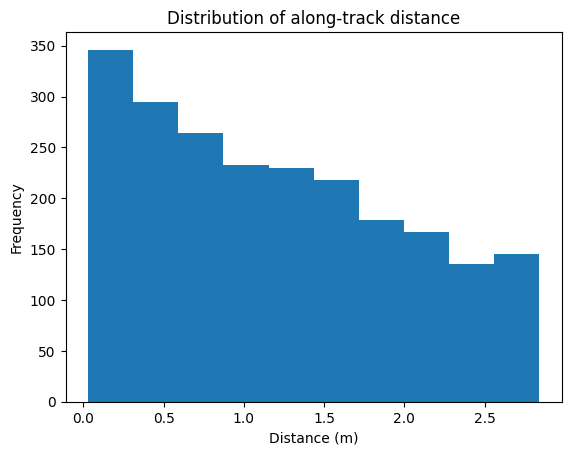

Max value: 2.84 nmi
Min value: 0.03 nmi


In [55]:
# todo 按距离/时间划分样本
# 划分后生成新json
# 重新计算map

import os
import pandas as pd
import matplotlib.pyplot as plt

path_synth = os.path.join(
    ROOT_DATA, 
    'LARD_dataset_decompressed/LARD_test/LARD_test_synth/LARD_test_synth.csv')

df = pd.read_csv(path_synth, sep=';')

df.along_track_distance.plot(kind='hist')
plt.title('Distribution of along-track distance')
plt.xlabel('Distance (m)')
plt.ylabel('Frequency')
plt.show()

max_value = df.along_track_distance.max()
min_value = df.along_track_distance.min()

print(f'Max value: {max_value} nmi')
print(f'Min value: {min_value} nmi')

In [79]:
import pandas as pd

# 定义分组边界
bins = [0, 1, 2, 3]

# 使用pd.cut()函数对数据框进行分组
df['group'] = pd.cut(df.along_track_distance, bins=bins, labels=False)

# 打印分组结果
df_group = df.groupby('group')

for group_id in range(3):

    # 获取文件名列表
    file_list = df_group.get_group(group_id).image.apply(lambda x: os.path.basename(x)).to_list()
    print(f'group {group_id} has {len(file_list)} files')

    # 取标签

    # 取预测

    # 算误差
    

group
0    1011
1     759
2     442
dtype: int64
group 0 has 1011 files
group 1 has 759 files
group 2 has 442 files
